# Physics 381 Assignment \#6
Gisu Ham 10134838
# Least squares fitting

Assume that we have some sequence of measurements at times $t_i$
$$ y_i = y( t_i)$$

and some presumed model of the relationship

$$ \tilde y = f(t; \vec p) $$

expressed in terms of the independent variable and some model parameters $\vec p$.

For example, if our model is a straight line

$$ y = a x + b $$

then there are two parameters which can be thought of as a vector

$$ \vec p = \begin{bmatrix}
           a \\
           b 
         \end{bmatrix}
$$

## Good, better, best
How can we find which parameters provide the ``best'' fit to the data?

This requires that we select some quantitative measure of the fit quality.  Ideally, we would like to achieve a perfect fit so that the residual $r$ between model and data 

$$ r_i = y_i -  \tilde y_i$$

is equal to zero for each observation.  Failing that, we might try to make all the residuals as small as possible.  This can be tricky, because improving the fit for one point will often make it worse for some others.

A general measure of the distance between two N-dimensional vectors is

$$ \sum | r_i |^d $$

where for $d=2$ we obtain a quantity that in statistics is often called chi-squared

$$ \chi^2 = \sum | y_i - \tilde y_i(p_1,\ldots,p_K) |^2 $$

The best fit is assumed to correspond to minima in $\chi^2$ with respect to the model parameters

$$ \frac{\partial \chi^2}{\partial p_k} = 2 \sum \left( y_i - \tilde y_i \right) \frac{\partial \tilde y_i}{\partial p_k} $$

which in turn depends on how the model changes with respect to the parameters.  Note that this will in general require that we solve $K$ coupled non-linear equations

## Reading data

There are python tools for reading a huge range of different kinds of data.  For example, we can act like a web-browser and access the contents of anything with a URL (eg. http://www.data.com/1/2/3/data.txt).  This can get a little fiddly if we need to deal with anything but the simplest text files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sy
import random
import math 

import urllib.request

In [2]:
url = 'ftp://ftp.ncdc.noaa.gov/pub/data/paleo/icecore/antarctica/law/law2006.txt'
with urllib.request.urlopen(url) as fid:
    data = [ line.decode('cp1252') for line in fid]

In [3]:
print( data[0], '\n...\n', *data[170:181], '\n', *data[182:185], '...\n',*data[185+2000:185+2004] )

Law Dome Ice Core 2000-Year CO2, CH4, and N2O Data
 
...
 
 Column 1: Year AD 
 Column 2: CH4 Spline (ppb) 
 Column 3: Growth Rate (ppb/yr) 
 Column 4: NOAA04 scale 
 Column 5: Year AD 
 Column 6: CO2 Spline (ppm) 
 Column 7: Growth Rate (ppm/yr) 
 Column 8: Year AD 
 Column 9: N2O Spline (ppb) 
 Column 10: Growth Rate (ppm/yr) 
 
 YearAD CH4spl  GrwthRt NOAA04      YearAD  CO2spl  GrwthRt     YearAD  N2Ospl  GrwthRt  
 1       647.6    -0.5   655.5         1.0   276.7     0.1         1.0   264.2    -0.1
 2       647.1    -0.5   655.0         2.0   276.8     0.1         2.0   264.1    -0.1
 ...
 2003   1709.1     0.6  1730.0      2003.0   372.6     2.0      2003.0   317.8     0.8
 2004   1709.7     0.5  1730.5      2004.0   374.6     0.0      2004.0   318.6     0.0
 
 



One very useful tool is numpy.genfromtxt, which can read tables of data from local files, remote files, lists, buffers etc.  It has many handy options for dealing with complications such as extra non-data lines at the beginning or end.

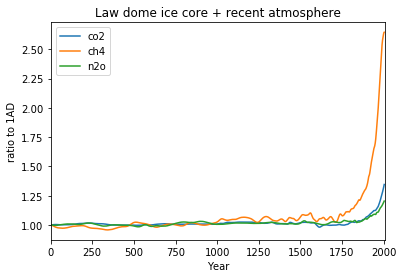

In [4]:
data = np.genfromtxt( url, skip_header=181, max_rows=2004, usecols=(0,1,5,8), names=['date', 'ch4', 'co2', 'n2o'] )
data.shape

for name in ['co2', 'ch4', 'n2o']:
    plt.plot( data['date'], data[name] / data[name][-2000], label=name)
plt.legend(loc=2)
plt.title('Law dome ice core + recent atmosphere')
plt.xlabel('Year')
plt.ylabel('ratio to 1AD')
plt.xlim(0,2010)
plt.show()

## Assignment \#6
Gisu Ham 10134838
## Due Wednesday March 22


0) Make a local copy of this data file

  ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt
  
  (older version http://cdiac.ornl.gov/ftp/trends/co2/maunaloa.co2)
  
so that you are not all downloading it every time we re-run the analysis.  Figure out how to read it using np.genfromtxt (or any other python tool). 

1) Always assume that any data file is incomplete, misleading, or simply full of errors.  Look at the contents, print selected values, and make summary plots.  Check for issues which need to be dealt with before trying any kind of analysis.

2) Use numpy or scipy routines to fit polynomials of degree 1-5 (1=linear, 2=quadratic, ...) to the "trend" (long term behaviour) in $CO_2$ concentration versus time.  Make useful figures showing the data, models, and residuals (not necessarily all on the same plot).  Also produce a table of $\chi^2$. Comment on the results.

3) Repeat step 2, but this time fit the logarithm of the concentration.  Compare results to step 2.

4) Use the models from questions 2 & 3 to predict $CO_2$ in the years 2050, 2100, and 2200.  What would be the corresponding increase in global temperature (since 1960) assuming that each doubling of atmospheric $CO_2$ will increase temperature by $3.5\pm 0.5^\circ$C?

https://en.wikipedia.org/wiki/Climate_sensitivity#Radiative_forcing_due_to_doubled_CO2

5) Try using a higher order polynomial to fit the annual variations as well as the long term trends.  Comment on the results.

# Intro 

First I import the data from the text file named co2.txt. Observation shows that np.genfromtxt does not import any entry of the data if it begins with #. Thankfully the data file provided contains # in front of any texts that are not data. So what is imported below are just raw data.

In [5]:
data1=np.genfromtxt('co2.txt')

"""For the entirety of the assignment, I want to be able to use any entry of the data.
    Therefore I create a list called column_space containing 7 different lists, one for each entry of the data."""
column_space=[[],[],[],[],[],[],[]]

for z in range(0,7):
    for i in range(0,len(data1)):
        column_space[z].append(data1[i][z])

The data file provides some information on missing data sets, they are denoted by -99.99 for missing monthly average and -1 for missing #days. Those missing entries are mostly concentrated at the beginning of the data (year 1958~1974). But the information in the text file assures us that for those missing entries, interpolated values are provided by considering average seasonal cycle throughout the entire data. So I don't see any need to discard any of the data. Some of the missing data are printed below.

In [6]:
print ('%-12s%-12s%-15s%-17s%-15s%-15s%-15s' % ('Year','Month','Decimal Date','Average','Interpolated','Trend','#days'))
for i in range(0,9):
    print ('%-12i%-12i%-17s%-15s%-15s%-13s%-15i' % (column_space[0][i],column_space[1][i],column_space[2][i],column_space[3][i],column_space[4][i],column_space[5][i],column_space[6][i]))
print('\n ... \n')
for i in range(192,197):
    print ('%-12i%-12i%-17s%-15s%-15s%-13s%-15i' % (column_space[0][i],column_space[1][i],column_space[2][i],column_space[3][i],column_space[4][i],column_space[5][i],column_space[6][i]))




Year        Month       Decimal Date   Average          Interpolated   Trend          #days          
1958        3           1958.208         315.71         315.71         314.62       -1             
1958        4           1958.292         317.45         317.45         315.29       -1             
1958        5           1958.375         317.5          317.5          314.71       -1             
1958        6           1958.458         -99.99         317.1          314.85       -1             
1958        7           1958.542         315.86         315.86         314.98       -1             
1958        8           1958.625         314.93         314.93         315.94       -1             
1958        9           1958.708         313.2          313.2          315.91       -1             
1958        10          1958.792         -99.99         312.66         315.61       -1             
1958        11          1958.875         313.33         313.33         315.31       -1            

I now make plots of three different mole fractions of CO2, one for the Average, one for interpolated, and one for trend column.

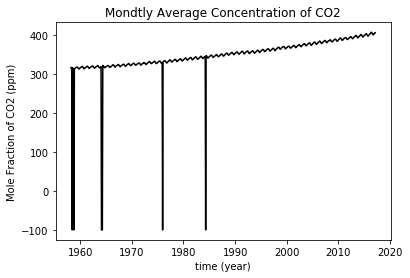

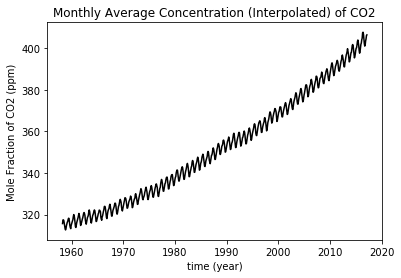

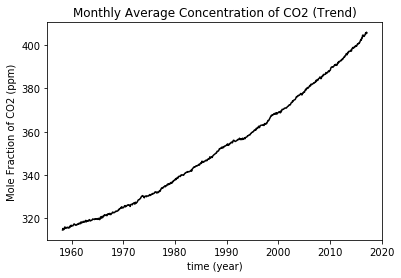

In [7]:
plt.plot(column_space[2],column_space[3],markersize=0.75,color='k')
plt.title("Mondtly Average Concentration of CO2")
plt.xlabel('time (year)')
plt.ylabel('Mole Fraction of CO2 (ppm)')
plt.show()

plt.plot(column_space[2],column_space[4],markersize=0.75,color='k')
plt.title("Monthly Average Concentration (Interpolated) of CO2")
plt.xlabel('time (year)')
plt.ylabel('Mole Fraction of CO2 (ppm)')
plt.show()

plt.plot(column_space[2],column_space[5],markersize=0.75,color='k')
plt.title("Monthly Average Concentration of CO2 (Trend)")
plt.xlabel('time (year)')
plt.ylabel('Mole Fraction of CO2 (ppm)')
plt.show()

In the first plot, As expected, the -99.99 points seriously distort the overall graph, so ideally one does not want to use the raw data from the Average column. In the second plot, seasonal cycles are plotted. Each year's CO2 level follow an osillatory behavior so that it creates many 'spikes' when plotted altogether. The last plot shows the overall trend by averaging the CO2 level for each year. This trend looks like the ideal data set to perform any kind of fit, presumably why the next part of the assignment requires polynomial fit to it.

But before I continue, I want to check one last thing that may be overlooked. I want to make sure that there are no skipped year or a skipped month. If any month or a year is skipped, then it would seriously damage the credibility of the data set as it shows that there were no careful treatment from the collectors of this data.

In [8]:
#Check month skip
TF=False
for i in range(0,len(data1)-1):
    if column_space[1][i]!=12: # if the month is not december, check next month - current month is 1
        if (column_space[1][i+1]-column_space[1][i])!=1:
            TF=True
            print("Month skip detected")
    elif column_space[1][i]==12: #if the month is december, check next month - current month is -11
        if (column_space[1][i+1]-column_space[1][i])!=-11:
            print('Month skip detected')
            TF=True
if TF==False:
    print('No month skip detected')
    
#Check year skip
TF=False
for i in range(1958,2018):
    if i not in column_space[0]:
        print('year skip detected')
        TF=True
if TF==False:
    print('No year skip detected.')

No month skip detected
No year skip detected.


It's looking good.

Below is my attempt to polynomial fit the 'CO2 trend' data using scipy.optimize.curve_fit rather than using numpy.polyfit. Ultimately, it works, but using it seriously made my life difficult in the later part of the assignment because curve_fit is very sensitive to guess values. Depending on the guess values, the chi square values fluctuate quite a lot. So in order to compensate for that, I made a loop that tries random guess values for some number of iterations and try to minimize the chi square. And doing so makes this function extremly time inefficient along with other several minor hindrances.

So for the purpose of grading this assignment, please ignore the box of code below. I left it there just for the amount of work that I put into it.

In [9]:
def Fit_me_poly_1_5(p,xindex,yindex,title="title",Plot=True,print_popt=False,threshold=100):
    """
    
    """
    if p==5:
        def func(x,a,b,c,d,e,f):
            return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f
    elif p==4:
        def func(x,a,b,c,d,e,f):
            return b*x**4 + c*x**3 + d*x**2 + e*x + f
    elif p==3:
        def func(x,a,b,c,d,e,f):
            return c*x**3 + d*x**2 + e*x + f
    elif p==2:
        def func(x,a,b,c,d,e,f):
            return d*x**2 + e*x + f
    elif p==1:
        def func(x,a,b,c,d,e,f):
            return e*x + f
    #popt,pcov=sy.curve_fit(func,column_space[xindex],column_space[yindex],p0=guess)
    #popt=np.polyfit(column_space[xindex],column_space[yindex],p)
    
    chi_list=[]
    popt_list=[]
    while threshold>1:
        
        random_guess=[]
        for i in range(0,6):
            random_guess.append(random.uniform(1, 65))
        try:
            popt,pcov=sy.curve_fit(func,column_space[xindex],column_space[yindex],p0=random_guess)
            
            yfit=[]
            for j in range(0,len(column_space[xindex])):
                yfit.append(func(column_space[xindex][j],popt[0],popt[1],popt[2],popt[3],popt[4],popt[5]))

            Chi_square=0.0
            for i in range(len(yfit)):
                Chi_square+=abs(yfit[i]-column_space[yindex][i])**2
            #print(Chi_square)
            
            chi_list.append(Chi_square)
            popt_list.append(popt)
        
        except:
            pass
        
        threshold=threshold-1
    #print("min",min(chi_list))
    #print("max",max(chi_list))
    bestindex=chi_list.index(min(chi_list))
    bestyfit=[]
    for j in range(0,len(column_space[xindex])):
        bestyfit.append(func(column_space[xindex][j],popt_list[bestindex][0],popt_list[bestindex][1],popt_list[bestindex][2],popt_list[bestindex][3],popt_list[bestindex][4],popt_list[bestindex][5]))
    
    bestpopt=popt_list[bestindex]
    
    if Plot==True:
        plt.figure(figsize=[12*2.2/4,10*2.2/4])
        plt.plot(column_space[xindex],column_space[yindex],'ko',markersize=0.75,color='k')
        plt.plot(column_space[xindex],bestyfit,'ko',markersize=0.75,color='r')
        plt.title(title)
        plt.xlabel('Time (year)')
        plt.ylabel('Mole Fraction of CO2 (ppm)')
        plt.show()
    
    residual=[]
    
    for i in range(len(yfit)):
        residual.append(column_space[yindex][i]-bestyfit[i])
    if Plot==True:
        plt.figure(figsize=[12*2.2/4,0.7*10*2.2/4])
        plt.plot(column_space[xindex],residual,'ko',markersize=1.95,color='k')
        plt.title(title+" (Residual Plot)")
        plt.xlabel('Time (year)')
        plt.ylabel('Residual of fit of Mole Fraction of CO2 (ppm)')
        plt.show()
    
    if print_popt==True:
        print('coefficient of polynomials a,b,c,d,e,f (a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f')
        print(bestpopt)
        
    Chi_square=0.0
    for i in range(len(bestyfit)):
        Chi_square+=abs(bestyfit[i]-column_space[yindex][i])**2
    print("Chi_Square value: ",Chi_square)
    
    return Chi_square,bestpopt

#chi_list.append(Fit_me_poly_1_5(1,2,5,title="Polynomial Fit of Degree 1",print_popt=True)[0])
#chi_list.append(Fit_me_poly_1_5(2,2,5,title="Polynomial Fit of Degree 2")[0])
#chi_list.append(Fit_me_poly_1_5(3,2,5,title="Polynomial Fit of Degree 3")[0])
#chi_list.append(Fit_me_poly_1_5(4,2,5,title="Polynomial Fit of Degree 4")[0])
#chi_list.append(Fit_me_poly_1_5(5,2,5,title="Polynomial Fit of Degree 5")[0])

#print("\n")
#print ('%-32s%-20s' % ('polynomial degree','Chi_square'))
#for i in range(0,5):
#    print ('%-32i%-20f' % (i+1,chi_list[i]))

Below is a polynomial fit of the 'trend CO2' using numpy.polyfit.

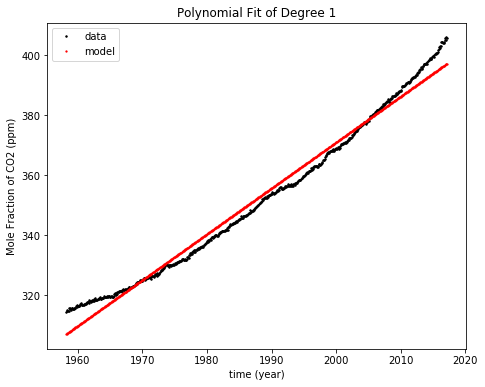

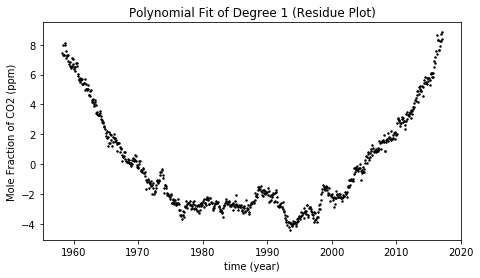

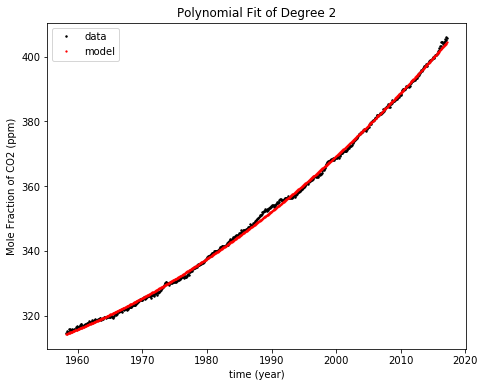

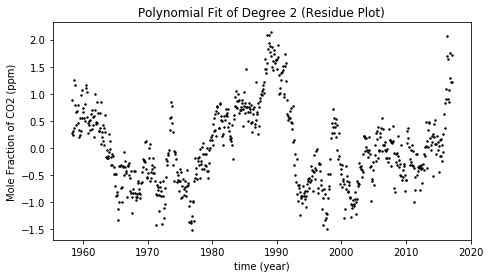

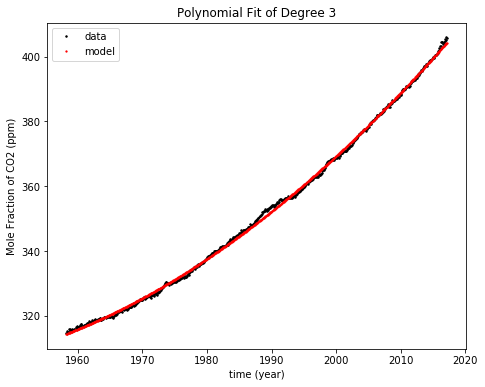

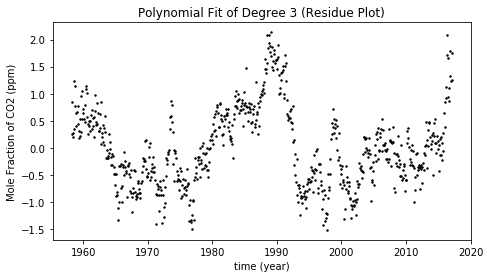

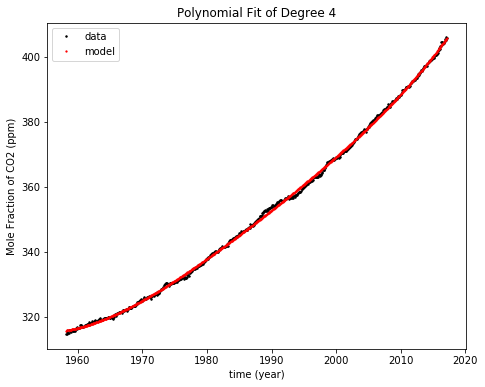

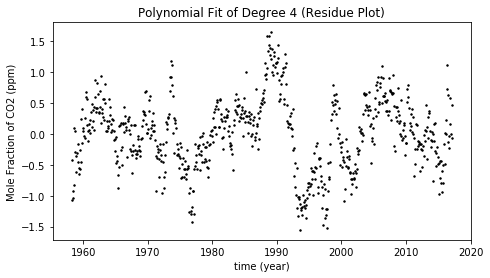

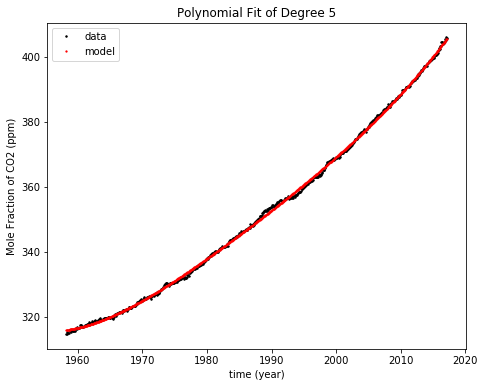

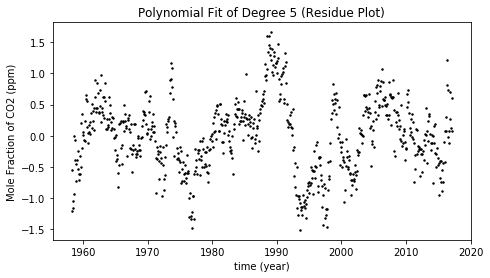

polynomial degree               Chi_square          
1                               7724.218918         
2                               373.634076          
3                               373.548588          
4                               234.363853          
5                               233.074379          


In [10]:
def Fit_me_poly_poly(p,xindex,yindex,Plot_fit=True,Plot_residue=True,Chi=True):
    """Fits polynomial to the data
    arguments:(p,xindex,yindex,Plot_fit=True,Plot_residue=True,Chi=True
    p= degree of polynomial
    xindex=index of the column of the data to be used as x
    yindex=index of the column of the data to be used as y
    the remaining arguments denote whether to plot fitted data, residues, and printing chi values."""
    
    #fit data and store the parameters for the polynomials.
    yfit=[]
    fit_data=np.polyfit(column_space[xindex],column_space[yindex],p)
    poly_func=np.poly1d(fit_data)
    
    
    for i in column_space[xindex]:
        yfit.append(poly_func(i))
    
    chi_sq=0.0
    for i in range(0,len(yfit)):
        chi_sq+=abs(column_space[yindex][i]-yfit[i])**2
    if Chi==True:
        print("chi_square=",chi_sq)
    
    if Plot_fit==True:
        plt.figure(figsize=[7.5,6])
        plt.plot(column_space[xindex],column_space[yindex],'ko',color='k',markersize=1.45,label="data")
        plt.plot(column_space[xindex],yfit,'ko',markersize=1.25,color='r',label="model")
        plt.title("Polynomial Fit of Degree "+str(p))
        plt.xlabel("time (year)")
        plt.ylabel("Mole Fraction of CO2 (ppm)")
        plt.legend()
        plt.show()
        
    if Plot_residue==True:
        residue=[]
        for i in range(0,len(yfit)):
            residue.append(column_space[yindex][i]-yfit[i])
            
        plt.figure(figsize=[7.5,4])
        plt.plot(column_space[xindex],residue,'ko',markersize=1.45,color='k')
        plt.title("Polynomial Fit of Degree "+str(p)+" (Residue Plot)")
        plt.xlabel("time (year)")
        plt.ylabel("Mole Fraction of CO2 (ppm)")
        plt.show()
        
        
    return chi_sq,fit_data

#tabulate data
chi_list=[]
for i in range(1,6):
    chi_list.append(Fit_me_poly_poly(i,2,5,Chi=False)[0])

print ('%-32s%-20s' % ('polynomial degree','Chi_square'))
for i in range(0,5):
    print ('%-32i%-20f' % (i+1,chi_list[i]))

I chose not to include unit for the chi square values because I cannot figure out its physical significance other than a simple statistical tool to determine the quality of the fit.

As expected, linear polynomial make a very poor fit to the trend. This claim is supported by both its residue plot and the chi square value. Polynomials of degree 4 and 5 have the minimum chi square values.

Next I try to polynomial fit the trend by applying log (base e) to its concentration values only

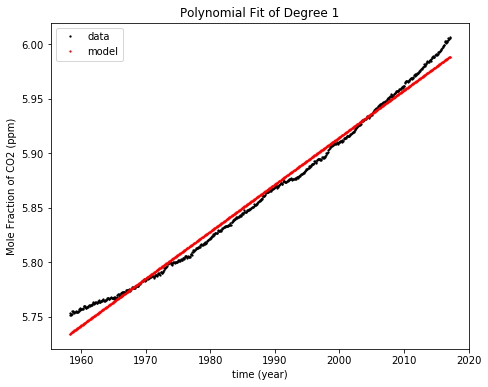

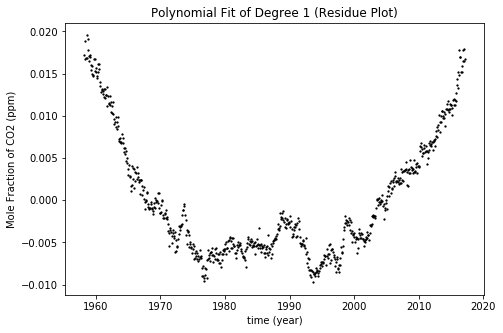

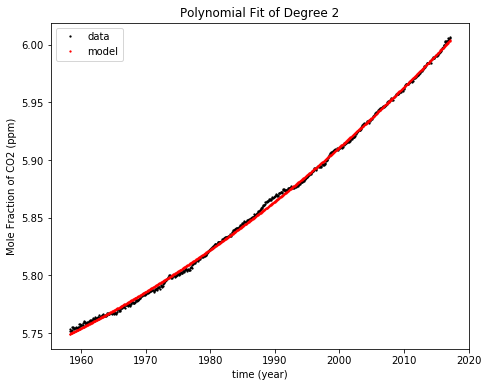

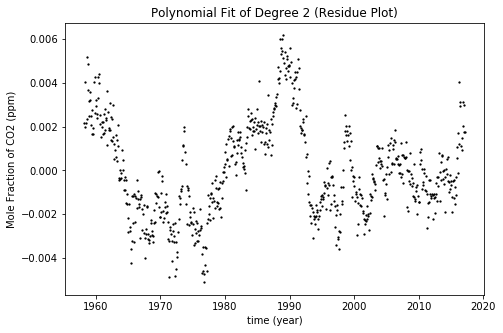

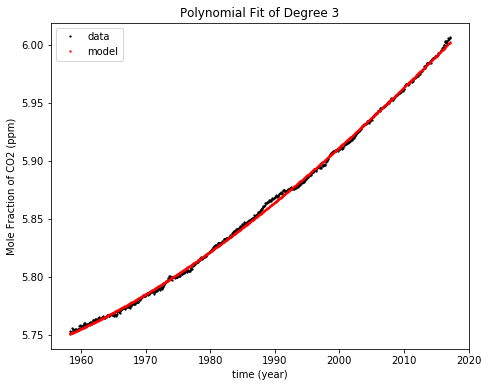

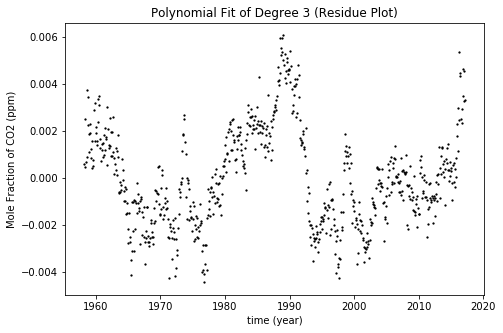

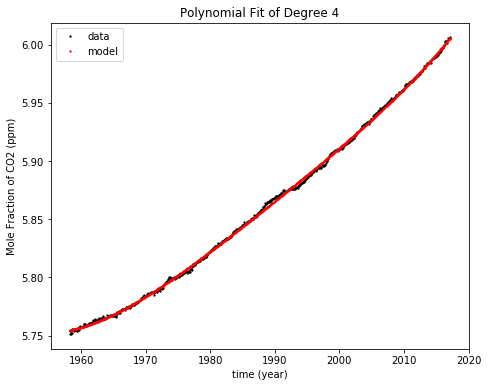

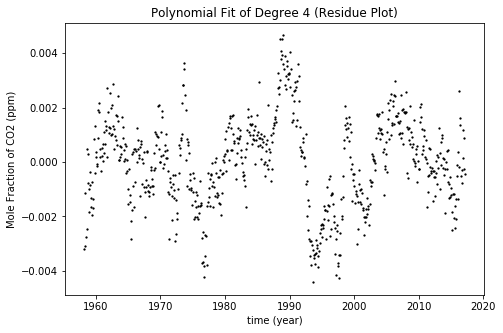

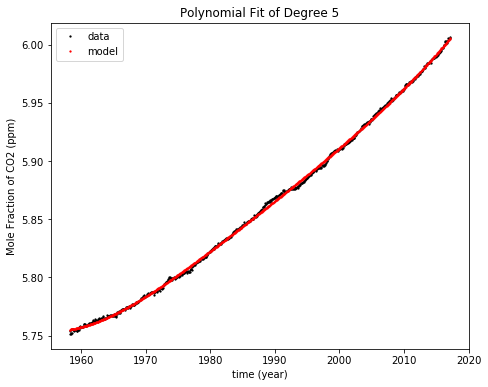

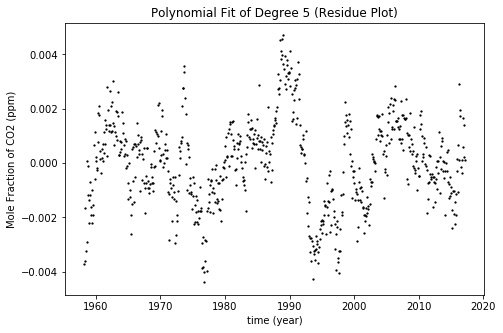

polynomial degree               Chi_square          
1                               0.035446            
2                               0.003300            
3                               0.003047            
4                               0.001903            
5                               0.001884            



In [11]:
def Fit_me_poly_poly_log(p,xindex,yindex,Plot_fit=True,Plot_residue=True,Chi=True):
    """Fits polynomial to the data
    arguments:(p,xindex,yindex,Plot_fit=True,Plot_residue=True,Chi=True
    p= degree of polynomial
    xindex=index of the column of the data to be used as x
    yindex=index of the column of the data to be used as y
    the remaining arguments denote whether to plot fitted data, residues, and printing chi values.
    same function as Fit_me_poly_poly, but only with log y values"""
    
    #fit data and store the parameters for the polynomials.
    yfit=[]
    fit_data=np.polyfit(column_space[xindex],np.log(column_space[yindex]),p)
    poly_func=np.poly1d(fit_data)
    
    
    for i in column_space[xindex]:
        yfit.append(poly_func(i))
    
    
    chi_sq=0.0
    chi_sq_conv=0.0
    for i in range(0,len(yfit)):
        chi_sq+=abs(np.log(column_space[yindex][i])-yfit[i])**2
        chi_sq_conv+=abs(column_space[yindex][i]-np.exp(yfit[i]))**2
    if Chi==True:
        print("chi_square=",chi_sq)
        print("chi_square=",chi_sq_conv)
    
    if Plot_fit==True:
        plt.figure(figsize=[7.5,6])
        plt.plot(column_space[xindex],np.log(column_space[yindex]),'ko',markersize=1.25,color='k',label="data")
        plt.plot(column_space[xindex],yfit,'ko',markersize=1.25,color='r',label="model")
        plt.title("Polynomial Fit of Degree "+str(p))
        plt.xlabel("time (year)")
        plt.ylabel("Mole Fraction of CO2 (ppm)")
        plt.legend()
        plt.show()
        
    if Plot_residue==True:
        residue=[]
        for i in range(0,len(yfit)):
            residue.append(np.log(column_space[yindex][i])-yfit[i])
            
        plt.figure(figsize=[7.5,5])
        plt.plot(column_space[xindex],residue,'ko',markersize=1.25,color='k')
        plt.title("Polynomial Fit of Degree "+str(p)+" (Residue Plot)")
        plt.xlabel("time (year)")
        plt.ylabel("Mole Fraction of CO2 (ppm)")
        plt.show()
        
        
    return chi_sq,fit_data,chi_sq_conv

    
chi_list=[]
chi_list_conv=[]

#tabulate data
for i in range(1,6):
    Fit_me_poly_poly_log(i,2,5,Chi=False)
    chi_list.append(Fit_me_poly_poly_log(i,2,5,Plot_fit=False,Plot_residue=False,Chi=False)[0])
    
print ('%-32s%-20s' % ('polynomial degree','Chi_square'))
for i in range(0,5):
    print ('%-32i%-20f' % (i+1,chi_list[i]))
print("")


Comparing this to the non-log plots, qualitatively, I see no major differences. When making comparison of the chi square values, It makes no sense to directly compare the chi values between log and non-log as we applied natural logarithm map to every single concentration values, but I can backtract and convert the values from log to non-log and vice versa. The result is shown below.

In [12]:
chi_list=[]
chi_list_conv=[]
for i in range(1,6):
    chi_list_conv.append(Fit_me_poly_poly_log(i,2,5,Plot_fit=False,Plot_residue=False,Chi=False)[2])
print("Non-logarithm")
print ('%-32s%-20s' % ('polynomial degree','Chi_square'))
for i in range(0,5):
    print ('%-32i%-20f' % (i+1,chi_list_conv[i]))
print("")

print("Non-logarithm after fitting using log")
chi_list=[]
for i in range(1,6):
    chi_list.append(Fit_me_poly_poly(i,2,5,Plot_fit=False,Plot_residue=False,Chi=False)[0])

print ('%-32s%-20s' % ('polynomial degree','Chi_square'))
for i in range(0,5):
    print ('%-32i%-20f' % (i+1,chi_list[i]))

Non-logarithm
polynomial degree               Chi_square          
1                               4372.994060         
2                               389.957249          
3                               375.008946          
4                               237.515756          
5                               233.176269          

Non-logarithm after fitting using log
polynomial degree               Chi_square          
1                               7724.218918         
2                               373.634076          
3                               373.548588          
4                               234.363853          
5                               233.074379          


It's clear that for the polynomial fits of degree 1,2 and 3, using log to fit the data improved the quality of the fit by a reasonable amount because it offers lower chi square values. But it's effect is minimal after degree 4.

Now I attempt to project future CO2 values using the models I obtained thus far along with the projected increase in temperature assuming that it's raised by $3.5\pm 0.5~K$ for each doubling of CO2.

Then since 
$$C(n)=C_o2^{n}$$ 
where $C_o$ is the initial concentration and n is the number of doubling of concentration. (n does not need to be an integer).  
Then for n doubling concentration, The temperature increased $\Delta T$ is as follows
$$\Delta T=n*(3.5\pm 0.5)~K$$
I also take the initial concentration of CO2 to be $316~ppm$

In [13]:
#store the parameters of the fifted data
mrl=[]
for i in range(1,6): 
    mrl.append(Fit_me_poly_poly(i,2,5,Plot_fit=False,Plot_residue=False,Chi=False)[1])
for i in range(1,6):
    mrl.append(Fit_me_poly_poly_log(i,2,5,Plot_fit=False,Plot_residue=False,Chi=False)[1])

def projection(year_val):
    """This function extrapolates the data using the specific parameters for the fitted function.
    argument= year int or float """

    year=year_val
    templist=[]
    print("Projected CO2 Concentration level in year ",year)
    print("")
    for i in range(0,5):
        poly_func=np.poly1d(mrl[i])
        templist.append(poly_func(year))
    for i in range(5,10):
        poly_func=np.poly1d(mrl[i])
        templist.append(np.exp(poly_func(year)))

    print ('%-32s%-40s%-20s' % ('polynomial degree','CO2 Concentration (ppm)','Temperature increased (K)'))
    for i in range(0,5):
        try:  # in case of negative input
            print ('%-32i%-40f%-20s' % (i+1,templist[i], str(3.5*(math.log(templist[i]/316,2)))+ " +/- " +str(0.5*(math.log(templist[i]/316,2)))))
        except:
            print ('%-32i%-40f%-20s' % (i+1,templist[i], "math domain error"))
    for i in range(5,10):
        print ('%-32s%-40f%-20s' % (str(i-4)+" (log)",templist[i],str(3.5*(math.log(templist[i]/316,2)))+ " +/- " +str(0.5*(math.log(templist[i]/316,2)))))

In [14]:
projection(2050)

Projected CO2 Concentration level in year  2050

polynomial degree               CO2 Concentration (ppm)                 Temperature increased (K)
1                               447.451774                              1.7563267383633387 +/- 0.25090381976619125
2                               492.101750                              2.2366123076490765 +/- 0.31951604394986804
3                               491.508209                              2.230518334778208 +/- 0.31864547639688684
4                               585.743201                              3.1162031040265714 +/- 0.44517187200379593
5                               549.918276                              2.797524367314312 +/- 0.39964633818775885
1 (log)                         459.711487                              1.892814547485539 +/- 0.27040207821221984
2 (log)                         504.704579                              2.3643011639926854 +/- 0.3377573091418122
3 (log)                         488.667084          

In [15]:
projection(2100)

Projected CO2 Concentration level in year  2100

polynomial degree               CO2 Concentration (ppm)                 Temperature increased (K)
1                               523.864837                              2.552445243762217 +/- 0.3646350348231739
2                               676.972086                              3.847101260696254 +/- 0.5495858943851791
3                               673.124943                              3.818324157321606 +/- 0.5454748796173723
4                               1824.889220                             8.854343486001524 +/- 1.264906212285932
5                               999.870518                              5.816358524572052 +/- 0.8309083606531502
1 (log)                         570.499641                              2.9830549746810644 +/- 0.4261507106687235
2 (log)                         785.796445                              4.599808788294518 +/- 0.6571155411849311
3 (log)                         637.396930                    

In [16]:
projection(2200)

Projected CO2 Concentration level in year  2200

polynomial degree               CO2 Concentration (ppm)                 Temperature increased (K)
1                               676.690963                              3.8450039717545184 +/- 0.5492862816792169
2                               1232.994334                             6.874593972409872 +/- 0.9820848532014103
3                               1206.205072                             6.763675601533774 +/- 0.966239371647682
4                               16568.088667                            19.993185838249392 +/- 2.856169405464199
5                               -4504.863865                            math domain error   
1 (log)                         878.608532                              5.163535829072117 +/- 0.737647975581731
2 (log)                         2812.159030                             11.03788601657087 +/- 1.5768408595101242
3 (log)                         654.733514                              3.678441445

In the year 2050, the extrapolated data does not do anything that's extremly out of ordinary. However, after 2100, it begins to show some erratic behavior. Some CO2 concentration outright explodes or is a negative value. This issue seems to be dominant for high order (4,5) polynomials. This suggests that although data fitting high degree polynomial offers lower chi square values in general, it makes for a poor extrapolation tool.

Next I try to fit the trend as well as the seasonal cycle (interpolated) using very high degrees of polynomial. First I test the limit of polyfit and try 100 degree polynomial.

In [17]:
Fit_me_poly_poly(100,2,4,Chi=False)

C:\Users\David\Miniconda3\lib\site-packages\numpy\lib\polynomial.py:587: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
C:\Users\David\Miniconda3\lib\site-packages\numpy\lib\polynomial.py:588: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


ValueError: On entry to DGELSD parameter number 4 had an illegal value

polyfit is not happy with 100 degree polynomial. So I tone it down a bit and try 45 degree fit to the seasonal cycle

C:\Users\David\Miniconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


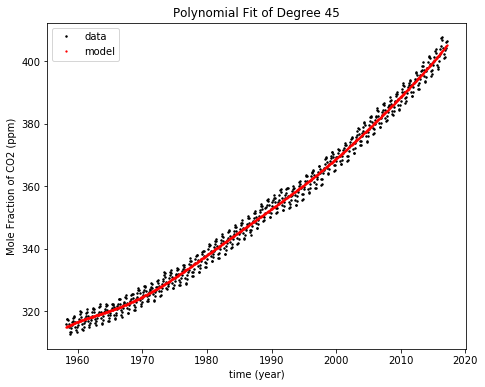

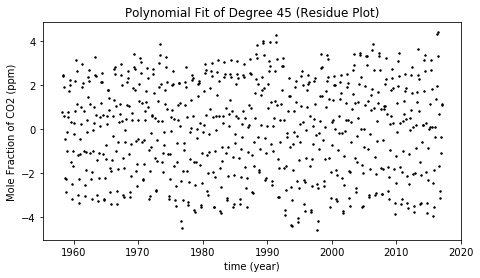

Chi square=  3242.84962441


In [18]:
print("Chi square= ",Fit_me_poly_poly(45,2,4,Chi=False)[0])

Of course it was obvious that 45 degree polynomial cannot perfectly fit the interpolated CO2 data because by inspection, the number of local maxima is well above 45, and n degree polynomial has at most 45-1 maximas. Then there is also the problem with polyfit's inability to handle such rapid oscillations.

Next is a 45 degree polynomial fit to the trend of CO2 concentration.

C:\Users\David\Miniconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


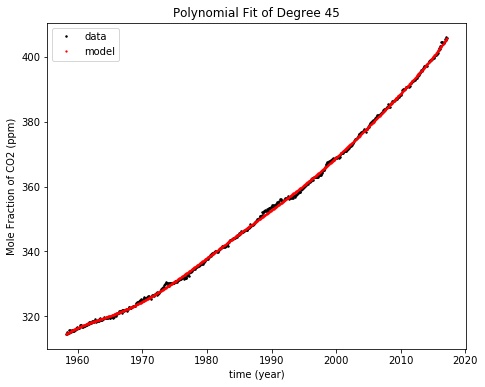

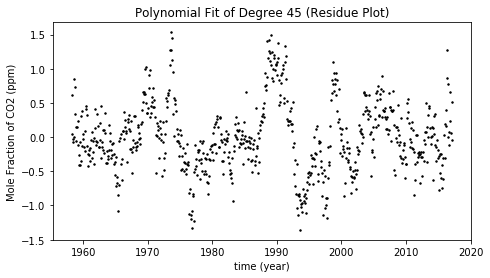

Chi square 182.651285159


In [19]:
print("Chi square",Fit_me_poly_poly(45,2,5,Chi=False)[0])

Of all the polynomial fit thus far, this fit has been the best as it's chi square value is the lowest, but it does come with certain complications when it comes to extrapolation like before. See below.

In [20]:
mrl=[]
mrl.append(Fit_me_poly_poly(45,2,5,Plot_fit=False,Plot_residue=False,Chi=False)[1])
mrl.append(Fit_me_poly_poly_log(45,2,5,Plot_fit=False,Plot_residue=False,Chi=False)[1])

def projection_high(year_val):
    """identical to projection function defined above. But modified to accomodate a specific degree of polynomial"""
    year=year_val
    templist=[]
    print("Projected CO2 Concentration level in year ",year)
    print("")
    poly_func=np.poly1d(mrl[0])
    templist.append(poly_func(year))
    poly_func=np.poly1d(mrl[1])
    templist.append(poly_func(year))

    print ('%-32s%-40s%-20s' % ('polynomial degree','CO2 Concentration (ppm)','Temperature increased (K)'))
    print ('%-32i%-40f%-20s' % (45,templist[0], str(3.5*(math.log(templist[0]/316,2)))+ " +/- " +str(0.5*(math.log(templist[0]/316,2)))))
    print ('%-32s%-40f%-20s' % (str(45)+" (log)",np.exp(templist[1]),str(3.5*(math.log(np.exp(templist[1])/316,2)))+ " +/- " +str(0.5*(math.log(np.exp(templist[1])/316,2)))))

C:\Users\David\Miniconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Users\David\Miniconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


In [21]:
projection_high(2050)
print("")
projection_high(2100)
print("")
projection_high(2200)

Projected CO2 Concentration level in year  2050

polynomial degree               CO2 Concentration (ppm)                 Temperature increased (K)
45                              4279.856265                             13.158480588590722 +/- 1.879782941227246
45 (log)                        18470107.938017                         55.42217874685858 +/- 7.917454106694082

Projected CO2 Concentration level in year  2100

polynomial degree               CO2 Concentration (ppm)                 Temperature increased (K)
45                              575560.741803                           37.90789771115808 +/- 5.415413958736869
45 (log)                        inf                                     inf +/- inf         

Projected CO2 Concentration level in year  2200

polynomial degree               CO2 Concentration (ppm)                 Temperature increased (K)
45                              155392194.260717                        66.1764531620524 +/- 9.453779023150343
45 (log)        

C:\Users\David\Miniconda3\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: overflow encountered in exp


These high degree polynomial extrapolations predict the scenario where the mankind has gone insane and made CO2 pollution their top priority (not very far from the truth). To save our world from this doomed future, we must make sure that there is nothing wrong with the data, but rather the problem is with the extrapolation using high degree polynomial. Consider

C:\Users\David\Miniconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


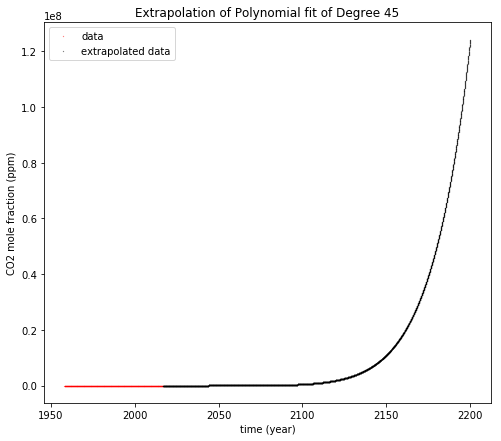

C:\Users\David\Miniconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Users\David\Miniconda3\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: overflow encountered in exp
C:\Users\David\Miniconda3\lib\site-packages\matplotlib\ticker.py:1755: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


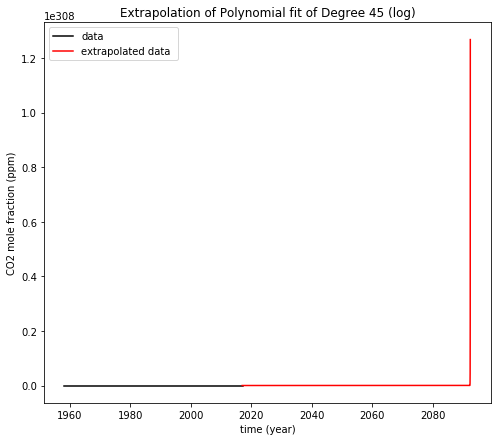

In [22]:
extra_list_x=np.linspace(2017,2200,num=5000)
extra_list_y=[]
mrl=Fit_me_poly_poly(45,2,4,Plot_fit=False,Plot_residue=False,Chi=False)[1]
poly_func=np.poly1d(mrl)

for i in extra_list_x:
    extra_list_y.append(poly_func(i))

plt.figure(figsize=[8,7])
plt.plot(column_space[2],column_space[5],'ko',color='r',markersize=0.2,label="data")
plt.plot(extra_list_x,extra_list_y,'ko',color='k',markersize=0.2,label="extrapolated data")
plt.title("Extrapolation of Polynomial fit of Degree 45")
plt.ylabel("CO2 mole fraction (ppm)")
plt.xlabel("time (year)")
plt.legend()
plt.show()

extra_list_x=np.linspace(2017,2200,num=25000)
extra_list_y=[]
mrl=Fit_me_poly_poly_log(45,2,4,Plot_fit=False,Plot_residue=False,Chi=False)[1]
poly_func=np.poly1d(mrl)

for i in extra_list_x:
    extra_list_y.append(np.exp(poly_func(i)))

plt.figure(figsize=[8,7])
plt.plot(column_space[2],column_space[5],color='k',label="data")
plt.plot(extra_list_x,extra_list_y,color='r',label="extrapolated data ")
plt.title("Extrapolation of Polynomial fit of Degree 45 (log)")
plt.ylabel("CO2 mole fraction (ppm)")
plt.xlabel("time (year)")
plt.legend()
plt.show()



First plot is the extrapolation of non log plot. The extrapolated values unusually diverge significantly. As for the extrapolation of the log, it diverged so much, it turned into a square. Unfortunately this square is somewhat misleading. Consider an identical plot below.

C:\Users\David\Miniconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Users\David\Miniconda3\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: overflow encountered in exp
C:\Users\David\Miniconda3\lib\site-packages\matplotlib\ticker.py:1755: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


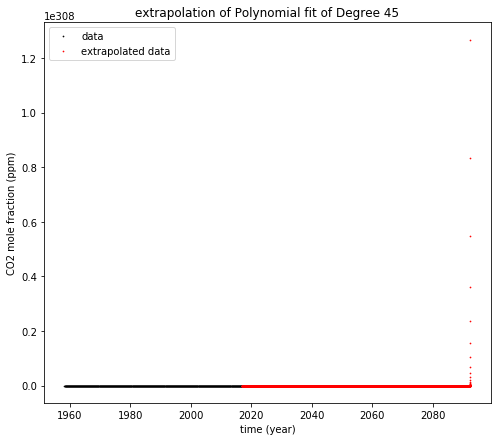

In [23]:
extra_list_x=np.linspace(2017,2200,num=25000)
extra_list_y=[]
mrl=Fit_me_poly_poly_log(45,2,4,Plot_fit=False,Plot_residue=False,Chi=False)[1]
poly_func=np.poly1d(mrl)

for i in extra_list_x:
    extra_list_y.append(np.exp(poly_func(i)))

plt.figure(figsize=[8,7])
plt.plot(column_space[2],column_space[5],'ko',color='k',markersize=0.7,label="data")
plt.plot(extra_list_x,extra_list_y,'ko',color='r',markersize=0.7,label="extrapolated data")
plt.title("extrapolation of Polynomial fit of Degree 45")
plt.ylabel("CO2 mole fraction (ppm)")
plt.xlabel("time (year)")
plt.legend()
plt.show()

What seemed like a square, is just a different way of viewing just how fast it diverges shortly after the year 2080. In fact, python recognizes the next data point as an infinity, which is why the plot stops before 2100 even though I specified the domain to be 2017-2200. Based on such fast divergence, it's somewhat clear the extrapolation is highly inaccurate.

# Conclusion
I looked at fitting of various degrees of polynomial on the provided data set. Then based on the fit, I extrapolated the data and predicted the tempeature corresponding to the future years. It's clear that polynomial fit is a very complicated matter. Low degree polynomial fit may not provide sufficiently low chi square value, but using high degree polynomial makes it difficult to extrapolate the data because the gradient outside the domain of the data tend to be very high.